## Data prep

* original_embeddings: 1854 concepts * 49 features (euclidean)
* memorability scores
* category mappings: 1324 concepts in 27 higher-level categories
* feature names
* typicality scores: average similarity of 1619 concepts within category


In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import re, seaborn as sns

data_dir = '../data'
output_dir = '../albatross_49_5D/outputs'

In [2]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [3]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [4]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


In [5]:
### load feature names
feat_short = loadmat(os.path.join(data_dir, 'labels_short.mat'))
feat_short_names = [item[0] for item in feat_short['labels_short'][0]]
features = loadmat(os.path.join(data_dir, 'labels.mat'))
feat_name = [item[0][0] for item in features['labels']]
feat_name

['made of metal / artificial / hard',
 'food-related / eating-related / kitchen-related',
 'animal-related / organic',
 'clothing-related / fabric / covering',
 'furniture-related / household-related / artifact',
 'plant-related / green',
 'outdoors-related',
 'transportation / motorized / dynamic',
 'wood-related / brownish',
 'body part-related',
 'colorful',
 'valuable / special occasion-related',
 'electronic / technology',
 'sport-related / recreational activity-related',
 'disc-shaped / round',
 'tool-related',
 'many small things / course pattern',
 'paper-related / thin / flat / text-related',
 'fluid-related / drink-related',
 'long / thin',
 'water-related / blue',
 'powdery / fine-scale pattern',
 'red',
 'feminine (stereotypically) / decorative',
 'bathroom-related / sanitary',
 'black / noble',
 'weapon / danger-related / violence',
 'musical instrument-related / noise-related',
 'sky-related / flying-related / floating-related',
 'spherical / ellipsoid / rounded / volumin

In [6]:
### load typicality score and merge with concepts
cat_typicality = loadmat(os.path.join(data_dir, 'typicality_data27.mat'))
concept_idx = []
concept_typ = []
concept_cat = []
for cat_idx in range(27):
    concept_idx.extend(pd.DataFrame(cat_typicality['category27_ind'][0][cat_idx])[0].to_list())
    concept_typ.extend(pd.DataFrame(cat_typicality['category27_typicality_rating_normed'][cat_idx][0])[0].to_list())
    concept_cat.extend([cat_idx+1 for i in range(len(cat_typicality['category27_ind'][0][cat_idx]))])
concept_typicality_rated = pd.DataFrame({'cat': concept_cat, 'concept': concept_idx, 'typicality': concept_typ})
concept_typicality_rated['concept'] = concept_typicality_rated['concept']-1
concept_typicality_rated

,cat,concept,typicality
0,1,0,4.874352
1,1,12,6.374555
2,1,15,5.342846
3,1,24,4.655669
4,1,25,5.288886
...,...,...,...
1614,27,1602,7.456293
1615,27,1620,5.922099
1616,27,1684,5.219242
1617,27,1712,3.238293


## 49-dim Feature Space

1. Get 49-dim feature embeddings from albatross results (.npy)
2. Get loadings of 1854 concepts in 49-dim hyperbolic feature space
3. Euclidean vs. mobius vector addition: test out different values of S
4. Get average 49-dim feature space embeddings and 1854 concept loadings through procrustes
5. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
6. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        



In [7]:
### stack albatross outputs
output_dir = '../albatross_49_5D/outputs'
# embeddings = []
# for i in range(10):
#     tmp = np.load(os.path.join(output_dir, f'membatross_embeddings_49_4D_{i}.npy'))
#     embeddings.append(tmp)
# embeddings = np.dstack(embeddings)
# np.save(os.path.join(output_dir, 'membatross_embeddings_49_4D.npy'), embeddings)

In [12]:
# 49-dim feature space embeddings
feature_embeddings = np.load(os.path.join(output_dir, 'membatross_embeddings_49_5D.npy'))
feature_embeddings.shape

(49, 5, 500)

1. `feature_embeddings`: output of ALBATROSS, embbeddings of 49 features that represent where 49 features locate in the 3D hyperbolic space. 
2. By multiplying `original_embeddings` (representations of 1854 concepts in 49-dim euclidean feature space) with `feature_embeddings`, we got `concept_in_feat_coord` that contains the loadings of 1854 concepts in hyperbolic space.
3. Instead of euclidean matrix multiplication (sum of loading * each feature vector), we used einstein scalar multiplication and mobius gyrovetor addition to transform 1854 concepts loadings from 49 feature dimensional space to 3d hyperbolic space. By doing this, loadings on each feature vector were multiplied and added in hyperbolic way, where the parameter S controlled the maximum length of vector (max radius of hyperbolic space).

In [13]:
### normalize embeddings and transform concept embeddings to loadings in hyperbolic feature space
concept_in_feat_coord = []
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
for layer in range(feature_embeddings.shape[-1]):
    concept_in_feat_coord.append(normalized_embeddings@feature_embeddings[:,:,layer])
np.array(concept_in_feat_coord).shape

(500, 1854, 5)

Orthogonal procrustes looped through each layer and rotated them so that all layers closely mapped. 

In [14]:
### procrustes of concept loadings in hyperbolic feature space
concept_in_feat_reference = concept_in_feat_coord[0]
concept_in_feat_output = [concept_in_feat_reference]
for i in range(1, len(concept_in_feat_coord)):
    R, scale = orthogonal_procrustes(concept_in_feat_coord[i], concept_in_feat_reference)
    concept_in_feat_output.append(concept_in_feat_coord[i]@R)
concept_in_feat_reference

array([[ -0.95276856,  -3.91332988,  -1.47018397,  -0.94698832,
        -33.63444604],
       [  9.47511669,  -4.55811906, -13.64043154, -13.07608457,
        -22.6530944 ],
       [  2.633313  ,  -1.47836099,   9.55864899, -11.01351482,
        -34.91514447],
       ...,
       [  3.86301105,  -2.14548677,  -0.98116361,   3.38742931,
        -34.37022197],
       [ -3.67842375,  -0.35438964,   8.31690901, -20.56752961,
         10.933028  ],
       [ 23.08189672, -18.33883859,  -1.49902113,  -1.62821456,
        -11.12398519]])

In [15]:
### procrustes of feature embeddings
feature_embed_reference = feature_embeddings[:,:,0]
feature_embed_output = [feature_embed_reference]
for i in range(1, feature_embeddings.shape[-1]):
    R, scale = orthogonal_procrustes(feature_embeddings[:,:,i], feature_embed_reference)
    feature_embed_output.append(feature_embeddings[:,:,i]@R)

In [16]:
### average across 500 layers
mean_concept_in_feat = np.array(concept_in_feat_output).mean(axis=0)
mean_feature_embed = np.array(feature_embed_output).mean(0)

In [17]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(mean_concept_in_feat).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,cr,bigcat,cat_name
0,0,-3.175620,-3.230498,1.610245,0.784191,-23.486532,0.779739,1,animal
1,1,5.203860,-6.154479,-5.496461,-21.416855,-5.364475,0.798485,13,home decor
2,2,1.506998,-2.876097,1.402605,-23.397392,-5.519164,0.752845,18,musical instrument
4,4,3.461573,-7.484285,-3.130044,-17.153949,1.066825,0.794466,9,electronic device
5,5,0.283580,-12.688717,-3.592896,-16.840011,-3.229937,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...
1847,1847,-5.984330,-7.065097,-8.038232,-12.377857,-8.080542,0.803129,24,toy
1848,1848,1.051345,-25.016664,-1.051580,-3.120613,-6.188148,0.765881,10,food
1850,1850,-0.275887,-25.198706,-3.784909,-1.879166,-9.155138,0.843158,10,food
1851,1851,-1.372886,-3.626559,0.306580,-1.510485,-21.924238,0.800163,1,animal


<IPython.core.display.Javascript object>


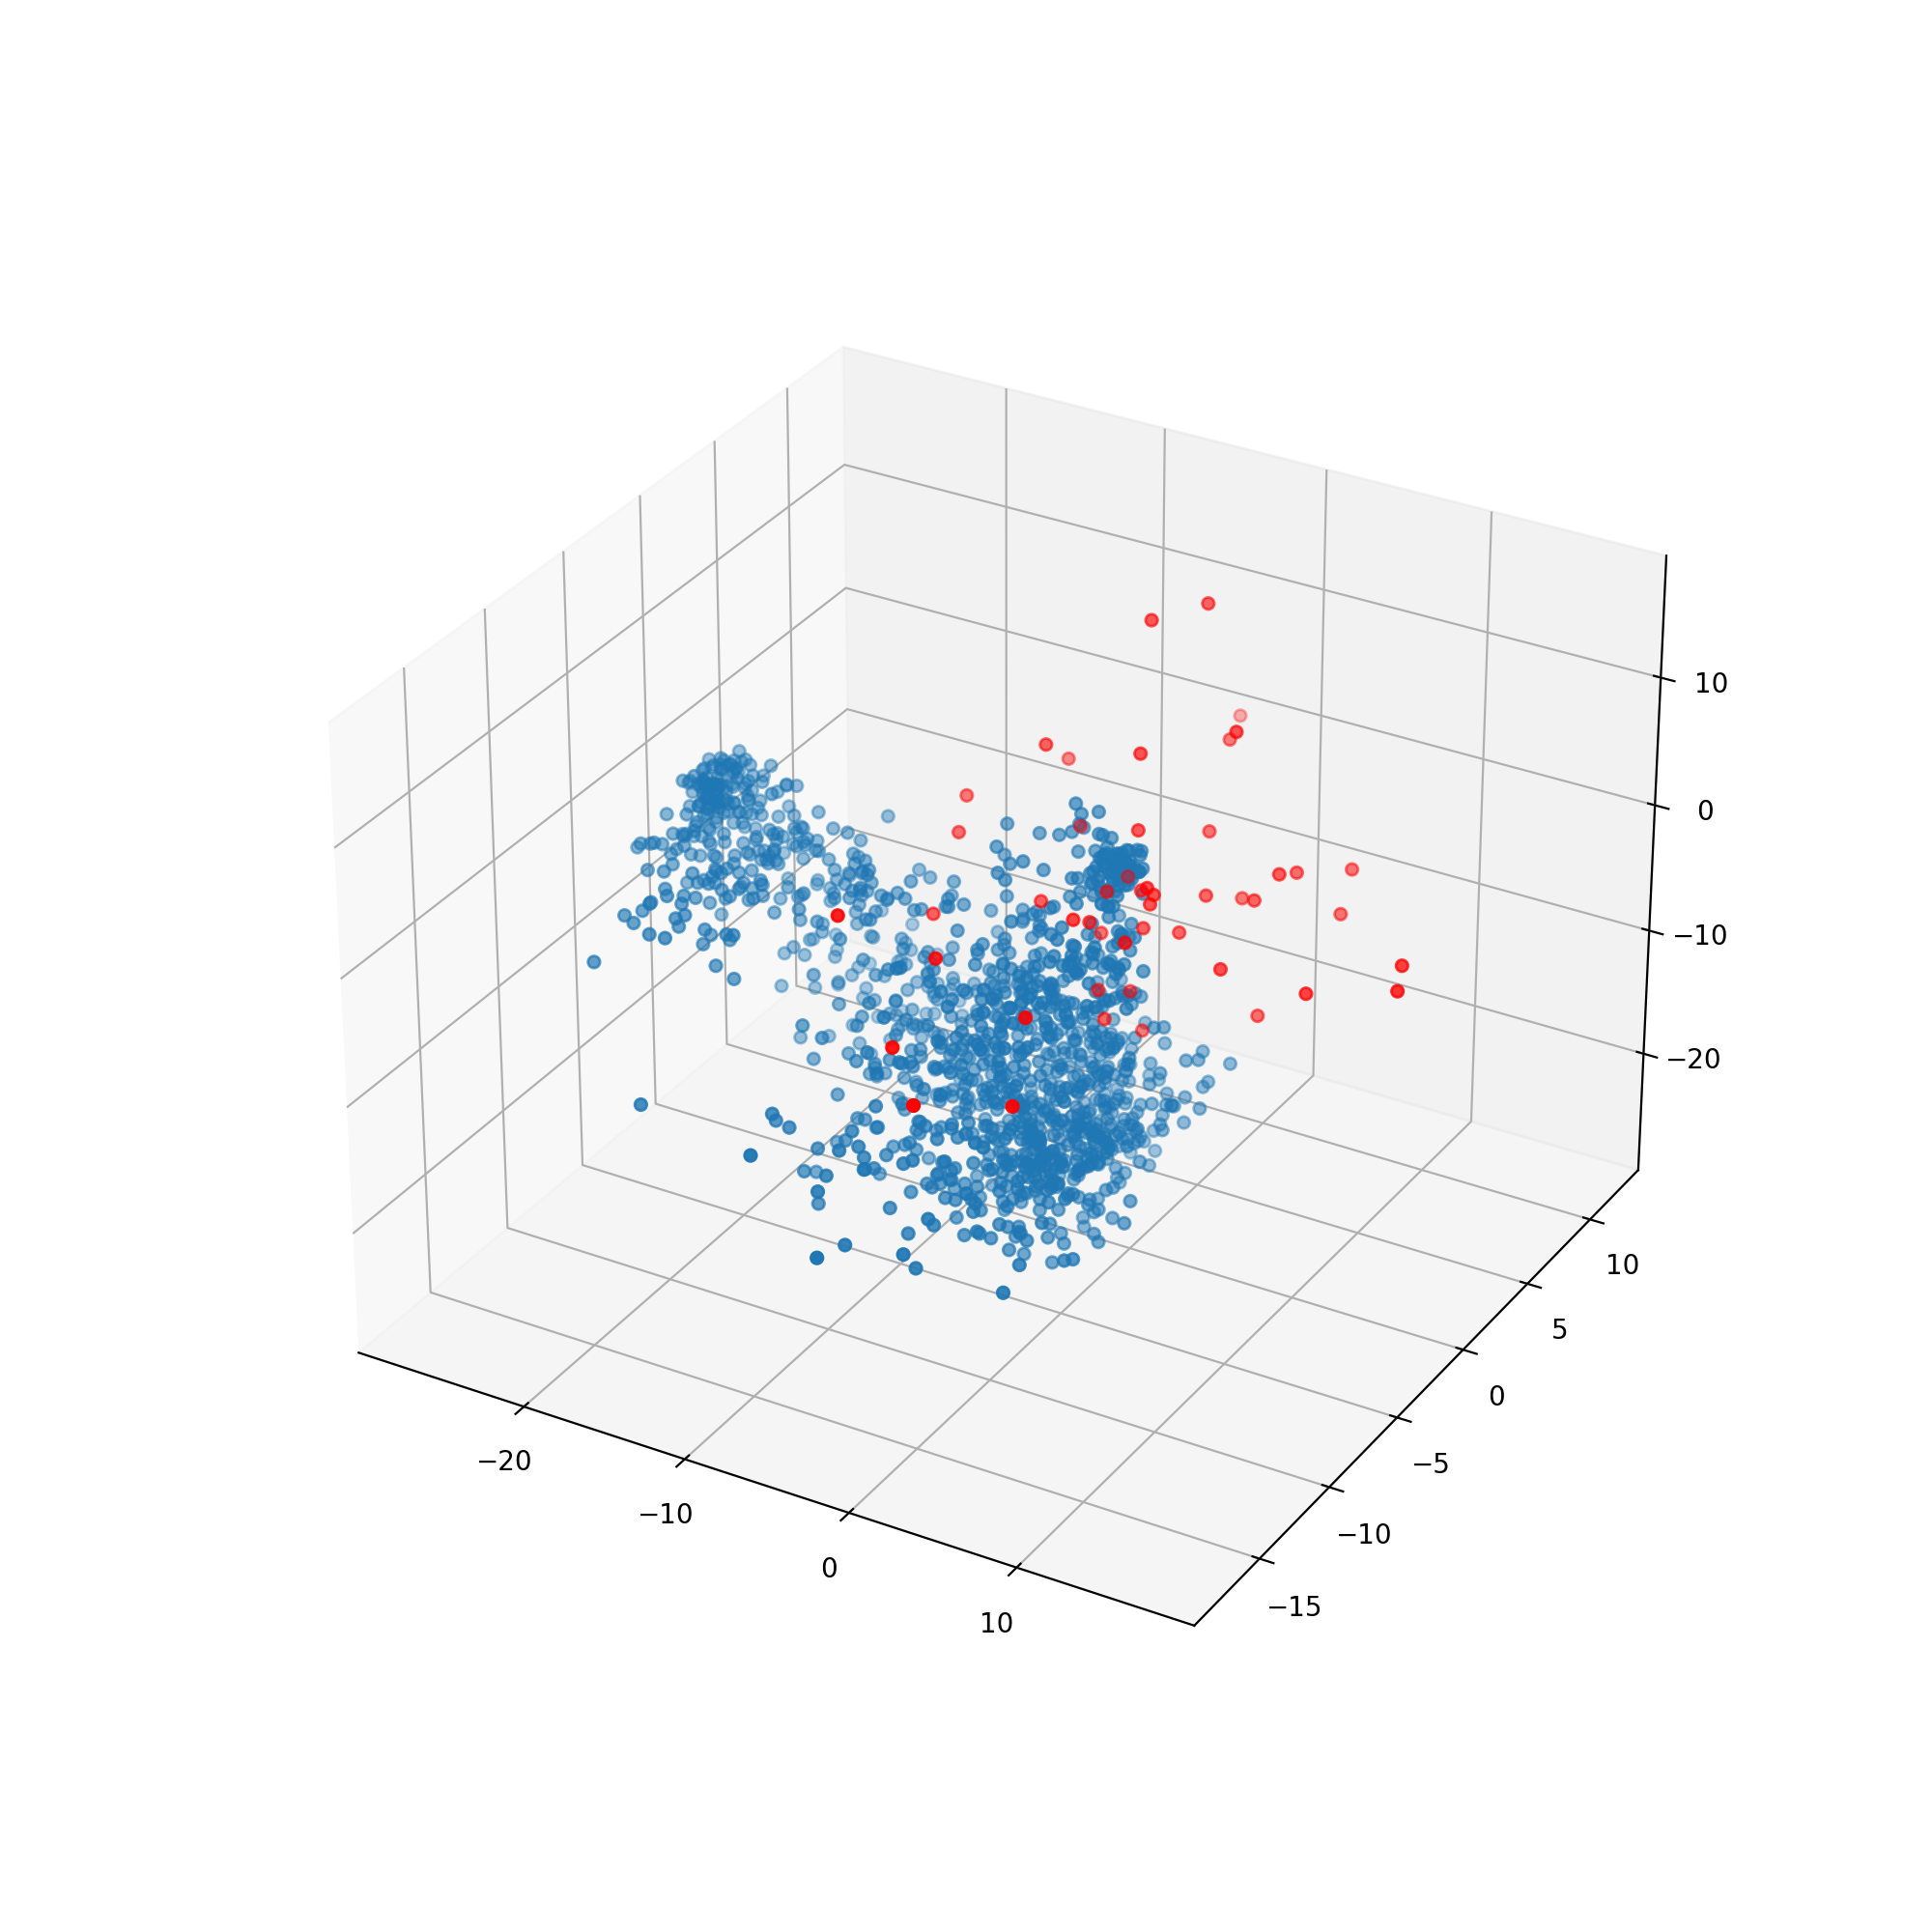

In [18]:
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

concept_cat = ax.scatter(mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2], mean_concept_in_feat_cat_na[3]) 

ax.scatter(mean_feature_embed.T[1], mean_feature_embed.T[2], mean_feature_embed.T[3], color='red')

plt.show()

### Analysis: coordinates vs. memorability

#### Cartesian coordinates
Cartesian coordinates of concepts explained 9.8% of variance in memorability, where x axis is most influential in memorability, while memorability decreased as coordinates going positively along y and z axes. 

In [19]:
### linreg: cartesian coordinates and z-score memorability
# normalized: R^2 = 0.098, adjusted = 0.096
# mobius: R^2 = 0.072, adjusted = 0.06
# mobius (S=48): R^2 = 0.117
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(mean_concept_in_feat_cat[[0,1,2,3,4]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     101.7
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           6.04e-95
Time:                        13:20:59   Log-Likelihood:                -2405.4
No. Observations:                1854   AIC:                             4823.
Df Residuals:                    1848   BIC:                             4856.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0513      0.003    -15.570      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### Polar coordinates
Predicting memorability using polar coordinates: polar coordinates explained less variance in memorability than cartesian coordinates. Vertical angle of concepts in the hyperbolic space is the most influential variable in predicting memorability, where concepts closer to the core are more memorable, and concepts closer to the ceiling/floor of the space are more forgettable. 

In [20]:
### Polar coordinates of concepts in hyperbolic feature space
r, theta, rho = cart_to_polar(mean_concept_in_feat_cat[[0,1,2,3]].values).T
plt.hist2d(theta, rho,
           bins = 20)

ValueError: too many values to unpack (expected 3)

In [21]:
### linreg: polar coordinates vs. memorability
# normalized: R^2 = 0.074, adjusted = 0.072
# mobius: R^2 = 0.019, adjusted = 0.018
# mobius (S=48): R^2 = 0.091
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

NameError: name 'r' is not defined

#### Radius
Predicting memorability using radius: radius of concepts in the hyperbolic space explained even smaller variance in memorability. Concepts that have shorter radius are closer to the core of the space and are more memorable. 

<IPython.core.display.Javascript object>


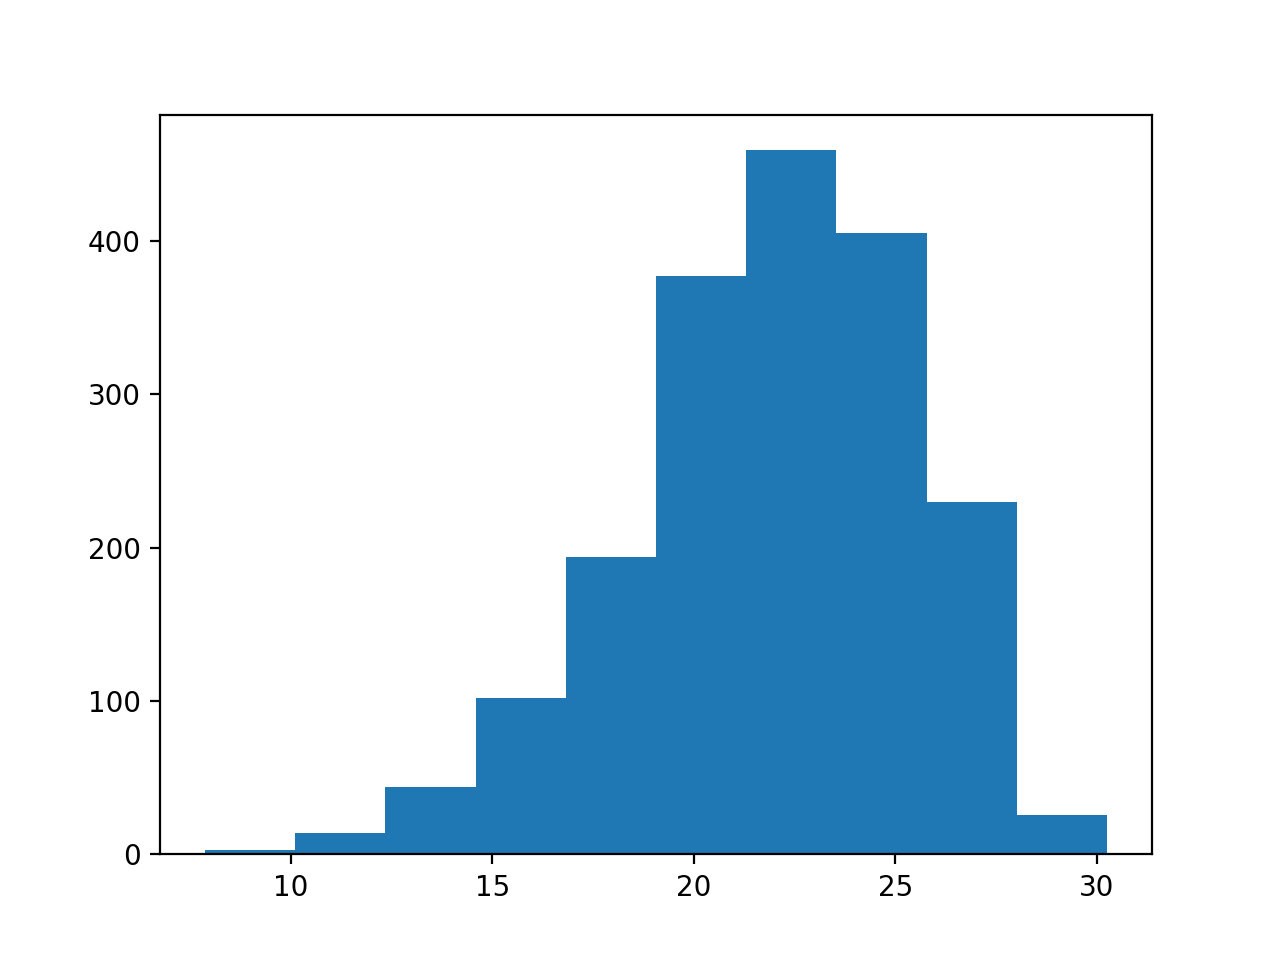

(array([  3.,  14.,  44., 102., 194., 377., 459., 405., 230.,  26.]),
 array([ 7.8652172 , 10.10430414, 12.34339107, 14.58247801, 16.82156495,
        19.06065189, 21.29973883, 23.53882577, 25.77791271, 28.01699965,
        30.25608658]),
 <BarContainer object of 10 artists>)

In [24]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((mean_concept_in_feat_cat[[0,1,2,3,4]]**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [25]:
### Radius vs. memorability
# normalized: R^2 = 0.037, adjusted = 0.037
# mobius: R^2 = 0.014, adjusted = 0.013
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.189
Date:                Wed, 28 Sep 2022   Prob (F-statistic):             0.0129
Time:                        13:21:35   Log-Likelihood:                -2627.6
No. Observations:                1854   AIC:                             5259.
Df Residuals:                    1852   BIC:                             5270.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0164      0.007      2.488      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### K-Means
Concepts further away from the core are more memorable in all 4 clusters. Vertical angle has most significantly negative relation with memorability, showing that concepts that are vertically further away from origin are more forgettable. 

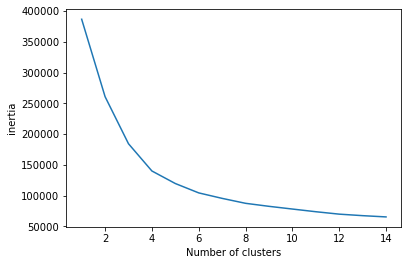

In [27]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2,3,4]])
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)

%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()

In [28]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2,3,4]])
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[  2.82128505, -20.64647756,  -1.5710736 ,  -4.81568591,
         -7.10913898],
       [ -9.61083134,  -5.36376838,  -2.04185314, -13.86513428,
         -6.53364367],
       [  2.94849937,  -4.82665483,  -2.61132351, -17.74970396,
         -3.80538215],
       [ -1.18176393,  -2.94637374,  -1.24935731,  -4.06343583,
        -22.91321373]])

<IPython.core.display.Javascript object>


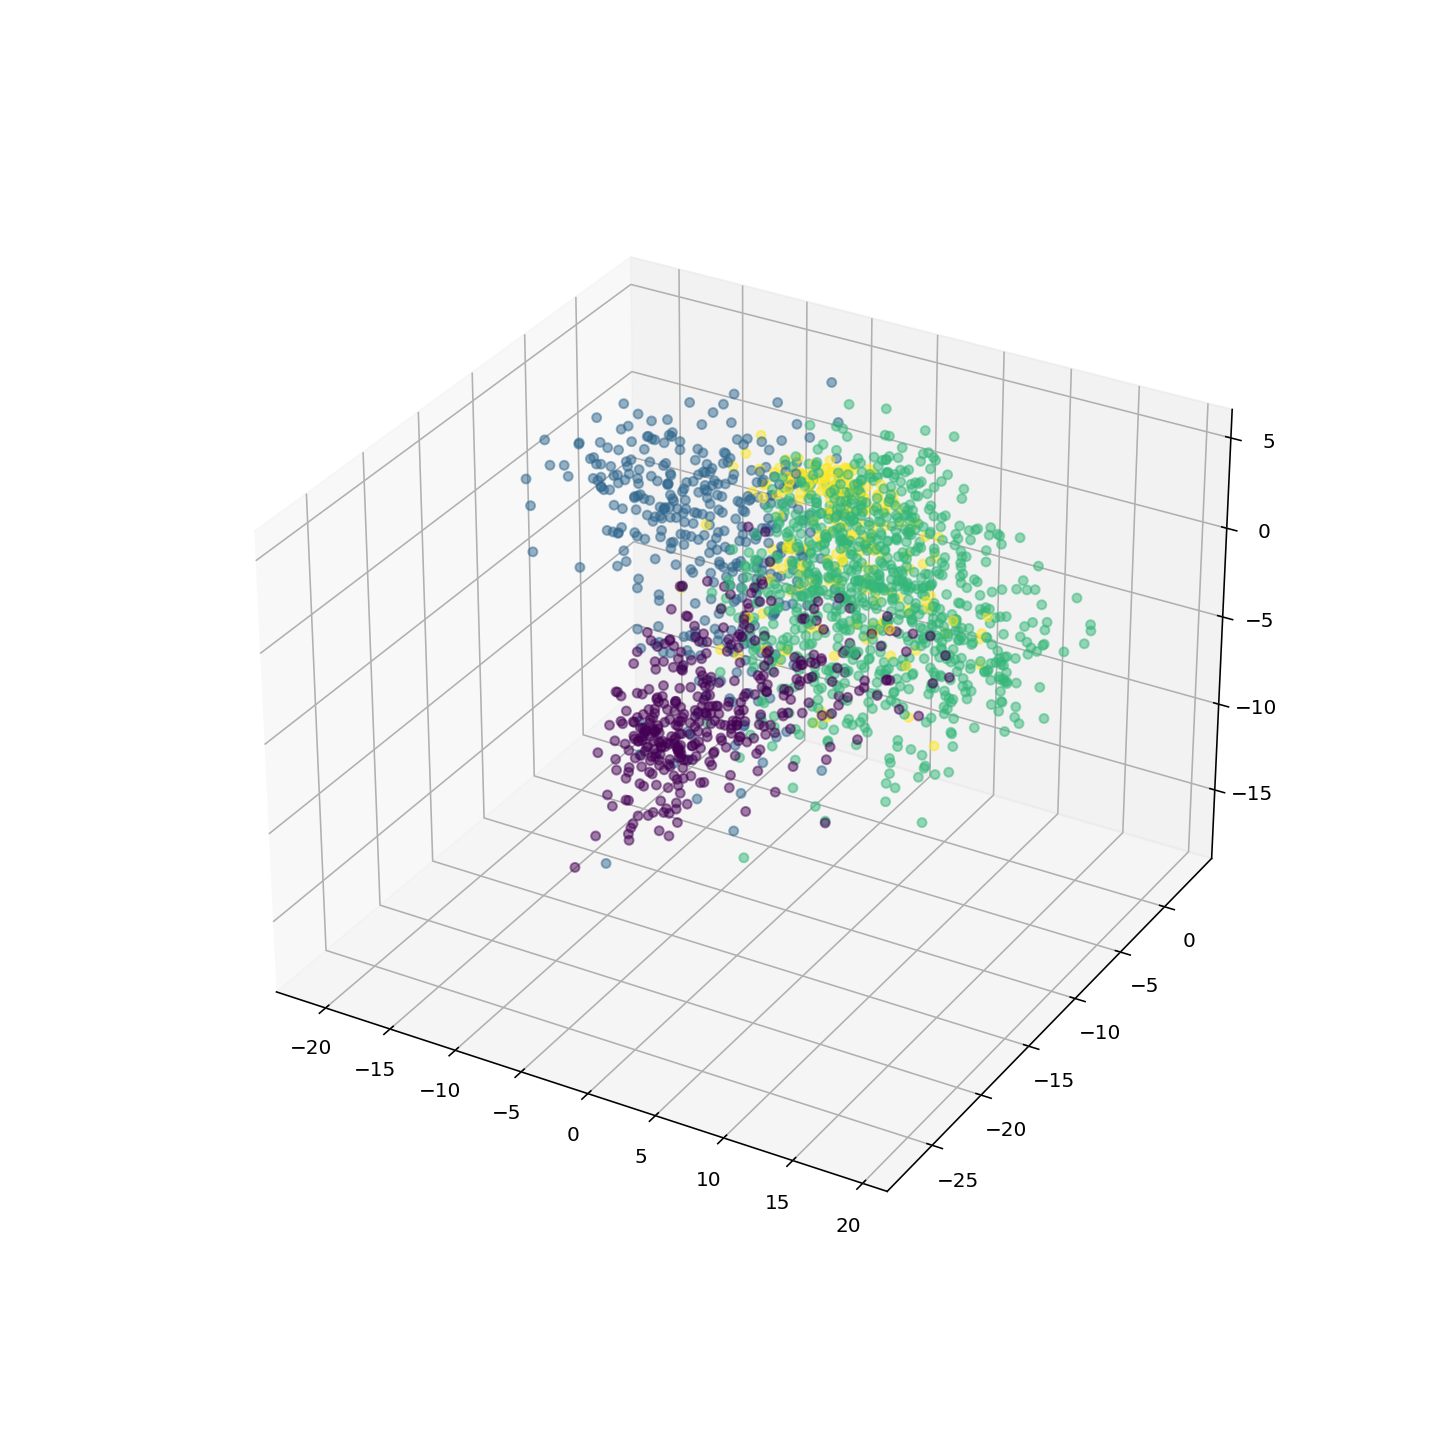

In [29]:
### clusters by memorability and plot concept coordinates in feature space
%matplotlib notebook


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(mean_concept_in_feat_cat[0], mean_concept_in_feat_cat[1], mean_concept_in_feat_cat[2], c=labels, alpha=0.5)


In [30]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3,4]], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     14.30
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           7.81e-13
Time:                        13:22:59   Log-Likelihood:                -513.02
No. Observations:                 385   AIC:                             1038.
Df Residuals:                     379   BIC:                             1062.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0139      0.016      0.858      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cart_to_polar(cluster_0[[0,1,2,3,4]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4]].values).mean(0)
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0, prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     13.42
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           4.65e-12
Time:                        13:23:07   Log-Likelihood:                -514.91
No. Observations:                 385   AIC:                             1042.
Df Residuals:                     379   BIC:                             1066.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0602      0.018      3.316      0.0

In [32]:
### cluster 0: radius vs. memorability
radius_0 = np.sqrt((cluster_0[[0,1,2,3,4]]**2).sum(1))
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_0, prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     46.47
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.62e-11
Time:                        13:23:14   Log-Likelihood:                -524.25
No. Observations:                 385   AIC:                             1052.
Df Residuals:                     383   BIC:                             1060.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1022      0.015      6.817      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [33]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,4]], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     37.69
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           5.00e-31
Time:                        13:23:20   Log-Likelihood:                -439.53
No. Observations:                 364   AIC:                             891.1
Df Residuals:                     358   BIC:                             914.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0609      0.011     -5.707      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cart_to_polar(cluster_1[[0,1,2,3,4]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4]].values).mean(0)
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1, prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     35.55
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.62e-29
Time:                        13:23:27   Log-Likelihood:                -443.12
No. Observations:                 364   AIC:                             898.2
Df Residuals:                     358   BIC:                             921.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0233      0.015     -1.592      0.1

In [35]:
### cluster 1: radius vs. memorability
radius_1 = np.sqrt((cluster_1[[0,1,2,3,4]]**2).sum(1))
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_1, prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2909
Date:                Wed, 28 Sep 2022   Prob (F-statistic):              0.590
Time:                        13:23:36   Log-Likelihood:                -516.35
No. Observations:                 364   AIC:                             1037.
Df Residuals:                     362   BIC:                             1044.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0082      0.015      0.539      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [36]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,4]], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     7.828
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.17e-07
Time:                        13:25:02   Log-Likelihood:                -1262.0
No. Observations:                 903   AIC:                             2536.
Df Residuals:                     897   BIC:                             2565.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0208      0.008     -2.524      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [37]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cart_to_polar(cluster_2[[0,1,2,3,4]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4]].values).mean(0)
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2, prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     7.838
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.10e-07
Time:                        13:25:09   Log-Likelihood:                -1262.0
No. Observations:                 903   AIC:                             2536.
Df Residuals:                     897   BIC:                             2565.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0528      0.011     -4.721      0.0

In [38]:
### cluster 2: radius vs. memorability
radius_2 = np.sqrt((cluster_2[[0,1,2,3,4]]**2).sum(1))
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_2, prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     29.46
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           7.35e-08
Time:                        13:25:13   Log-Likelihood:                -1266.8
No. Observations:                 903   AIC:                             2538.
Df Residuals:                     901   BIC:                             2547.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0565      0.010     -5.427      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [39]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,4]], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     22.67
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           6.38e-18
Time:                        13:25:17   Log-Likelihood:                -240.53
No. Observations:                 202   AIC:                             493.1
Df Residuals:                     196   BIC:                             512.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0441      0.019     -2.295      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [40]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cart_to_polar(cluster_3[[0,1,2,3,4]].values) - cart_to_polar(concept_coord_cluster[[0,1,2,3,4]].values).mean(0)
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3, prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     20.34
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           2.49e-16
Time:                        13:25:23   Log-Likelihood:                -244.41
No. Observations:                 202   AIC:                             500.8
Df Residuals:                     196   BIC:                             520.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1070      0.025      4.213      0.0

In [41]:
### cluster 3: radius vs. memorability
radius_3 = np.sqrt((cluster_3[[0,1,2,3,4]]**2).sum(1))
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_3, prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     24.32
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.71e-06
Time:                        13:25:26   Log-Likelihood:                -275.03
No. Observations:                 202   AIC:                             554.1
Df Residuals:                     200   BIC:                             560.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1212      0.025      4.932      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


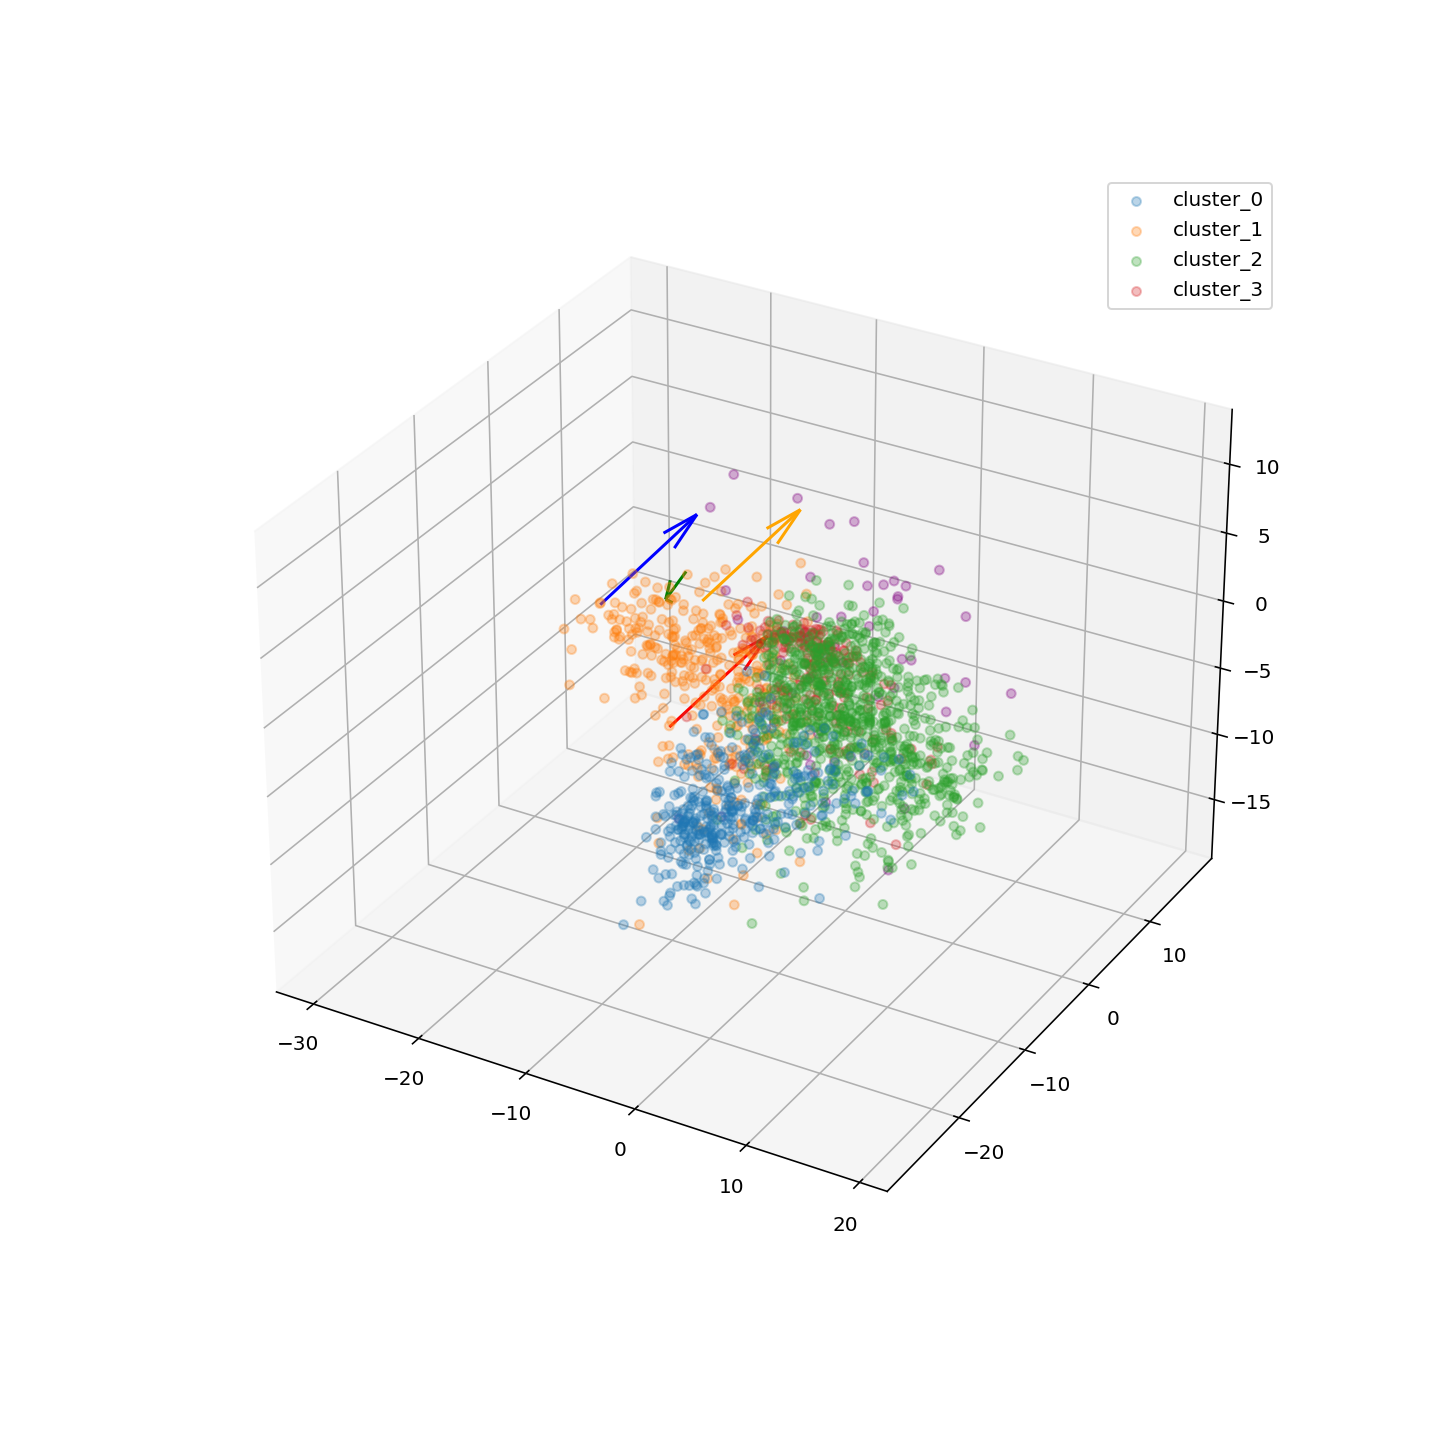

In [42]:
### Memorability changes by coordinates in each cluster
# normalized: highest R^2 (cluster 1) = 0.318
# mobius: highest R^2 (cluster 3) = 0.123

%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

plt.legend()


In [43]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.16095175289918162

In [44]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.15398012374864212

In [45]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.04986227924719833

### Analysis: coordinates, typicality, memorability


In [46]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [47]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,cr,bigcat,cat_name,typicality
0,0,-3.175620,-3.230498,1.610245,0.784191,-23.486532,0.779739,1,animal,0.810913
1,1,5.203860,-6.154479,-5.496461,-21.416855,-5.364475,0.798485,13,home decor,0.247628
2,2,1.506998,-2.876097,1.402605,-23.397392,-5.519164,0.752845,18,musical instrument,0.624589
4,4,3.461573,-7.484285,-3.130044,-17.153949,1.066825,0.794466,9,electronic device,0.522380
5,5,0.283580,-12.688717,-3.592896,-16.840011,-3.229937,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...
1847,1847,-5.984330,-7.065097,-8.038232,-12.377857,-8.080542,0.803129,24,toy,0.246697
1848,1848,1.051345,-25.016664,-1.051580,-3.120613,-6.188148,0.765881,10,food,0.786900
1850,1850,-0.275887,-25.198706,-3.784909,-1.879166,-9.155138,0.843158,10,food,0.770485
1851,1851,-1.372886,-3.626559,0.306580,-1.510485,-21.924238,0.800163,1,animal,0.764335


In [48]:
### Cartesian coordinates vs. typicality
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped[[0,1,2,3,4]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     154.5
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          2.79e-129
Time:                        13:26:45   Log-Likelihood:                -1573.3
No. Observations:                1324   AIC:                             3159.
Df Residuals:                    1318   BIC:                             3190.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0032      0.004      0.870      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [49]:
### Polar coordinates vs. typicality
polar_coord = pd.DataFrame(cart_to_polar(grouped[[0,1,2,3,4]].values))

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(polar_coord.values, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     174.1
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          2.27e-142
Time:                        13:26:55   Log-Likelihood:                -1542.9
No. Observations:                1324   AIC:                             3098.
Df Residuals:                    1318   BIC:                             3129.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0901      0.007     12.657      0.0

In [50]:
### Radius vs. typicality
concept_radius_typ = np.sqrt((grouped[[0,1,2,3,4]]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     337.0
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.23e-67
Time:                        13:27:12   Log-Likelihood:                -1728.4
No. Observations:                1324   AIC:                             3461.
Df Residuals:                    1322   BIC:                             3471.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1343      0.007     18.356      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [51]:
### typicality vs. memorability
# R^2 = 0.032, adjusted = 0.031

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(grouped['typicality'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.72
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           5.50e-11
Time:                        13:27:28   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1322   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
typicality     0.9536      0.144      6.612      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [52]:
### Cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array(grouped[[0,1,2,3,4,'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     61.81
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.17e-67
Time:                        13:27:32   Log-Likelihood:                -1714.4
No. Observations:                1324   AIC:                             3443.
Df Residuals:                    1317   BIC:                             3479.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0570      0.004    -13.851      0.0

In [53]:
### Polar coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

NameError: name 'r' is not defined

In [54]:
### Radius and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     24.35
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           4.12e-11
Time:                        13:27:48   Log-Likelihood:                -1854.7
No. Observations:                1324   AIC:                             3715.
Df Residuals:                    1321   BIC:                             3731.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7933      0.161      4.917      0.0

#### Cluster level typicality

In [107]:
# ### K-Means clustering on concepts
# kmeans = KMeans(n_clusters=4, random_state=42).fit(grouped[[0,1,2]])
# labels = kmeans.labels_
# concept_coord_cluster = grouped
# concept_coord_cluster['label'] = labels
# kmeans.cluster_centers_


In [55]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,4,cr,bigcat,cat_name,label,typicality
0,0,-3.175620,-3.230498,1.610245,0.784191,-23.486532,0.779739,1,animal,3,0.810913
1,1,5.203860,-6.154479,-5.496461,-21.416855,-5.364475,0.798485,13,home decor,2,0.247628
2,2,1.506998,-2.876097,1.402605,-23.397392,-5.519164,0.752845,18,musical instrument,2,0.624589
3,4,3.461573,-7.484285,-3.130044,-17.153949,1.066825,0.794466,9,electronic device,2,0.522380
4,5,0.283580,-12.688717,-3.592896,-16.840011,-3.229937,0.806000,12,furniture,2,0.509185
...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-5.984330,-7.065097,-8.038232,-12.377857,-8.080542,0.803129,24,toy,1,0.246697
1320,1848,1.051345,-25.016664,-1.051580,-3.120613,-6.188148,0.765881,10,food,0,0.786900
1321,1850,-0.275887,-25.198706,-3.784909,-1.879166,-9.155138,0.843158,10,food,0,0.770485
1322,1851,-1.372886,-3.626559,0.306580,-1.510485,-21.924238,0.800163,1,animal,3,0.764335


In [56]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3,4, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     7.950
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           5.18e-08
Time:                        13:28:06   Log-Likelihood:                -448.35
No. Observations:                 332   AIC:                             910.7
Df Residuals:                     325   BIC:                             937.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0071      0.018      0.386      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [57]:
### cluster 0: polar coordinates and typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2,3,4]] = cart_to_polar(cluster_0[[0,1,2,3,4]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,3,4,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     7.560
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.33e-07
Time:                        13:28:18   Log-Likelihood:                -449.40
No. Observations:                 332   AIC:                             912.8
Df Residuals:                     325   BIC:                             939.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0645      0.025      2.617      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [58]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:4]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     17.48
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           6.11e-08
Time:                        13:28:27   Log-Likelihood:                -454.33
No. Observations:                 332   AIC:                             914.7
Df Residuals:                     329   BIC:                             926.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0850      0.023      3.626      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [59]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,4,'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     19.92
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           5.63e-19
Time:                        13:28:35   Log-Likelihood:                -311.67
No. Observations:                 255   AIC:                             637.3
Df Residuals:                     248   BIC:                             662.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0665      0.015     -4.488      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
### cluster 1: polar coordinates and typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2,3,4]] = cart_to_polar(cluster_1[[0,1,2,3,4]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,3,4,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     18.50
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           9.42e-18
Time:                        13:28:43   Log-Likelihood:                -314.67
No. Observations:                 255   AIC:                             643.3
Df Residuals:                     248   BIC:                             668.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0099      0.019     -0.520      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:4]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     10.65
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.63e-05
Time:                        13:28:49   Log-Likelihood:                -351.49
No. Observations:                 255   AIC:                             709.0
Df Residuals:                     252   BIC:                             719.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0105      0.019      0.562      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,4,'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     4.398
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           0.000237
Time:                        13:28:56   Log-Likelihood:                -758.86
No. Observations:                 544   AIC:                             1532.
Df Residuals:                     537   BIC:                             1562.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0074      0.012     -0.645      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [63]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2,3,4]] = cart_to_polar(cluster_2[[0,1,2,3,4]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,3,4,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.622
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           0.000136
Time:                        13:29:08   Log-Likelihood:                -758.21
No. Observations:                 544   AIC:                             1530.
Df Residuals:                     537   BIC:                             1561.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0194      0.015     -1.263      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [64]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:4]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.547
Date:                Wed, 28 Sep 2022   Prob (F-statistic):             0.0295
Time:                        13:29:15   Log-Likelihood:                -768.36
No. Observations:                 544   AIC:                             1543.
Df Residuals:                     541   BIC:                             1556.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0285      0.015     -1.929      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [65]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,4,'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     19.31
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.88e-17
Time:                        13:29:21   Log-Likelihood:                -227.13
No. Observations:                 193   AIC:                             468.3
Df Residuals:                     186   BIC:                             491.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0617      0.021     -2.917      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [66]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2,3,4]] = cart_to_polar(cluster_3[[0,1,2,3,4]].values) - cart_to_polar(typ_coord_cluster[[0,1,2,3,4]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,3,4,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     16.16
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           6.18e-15
Time:                        13:29:33   Log-Likelihood:                -233.37
No. Observations:                 193   AIC:                             480.7
Df Residuals:                     186   BIC:                             503.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1256      0.028      4.531      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [67]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:4]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     22.01
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           2.54e-09
Time:                        13:29:38   Log-Likelihood:                -253.75
No. Observations:                 193   AIC:                             513.5
Df Residuals:                     190   BIC:                             523.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1140      0.025      4.540      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


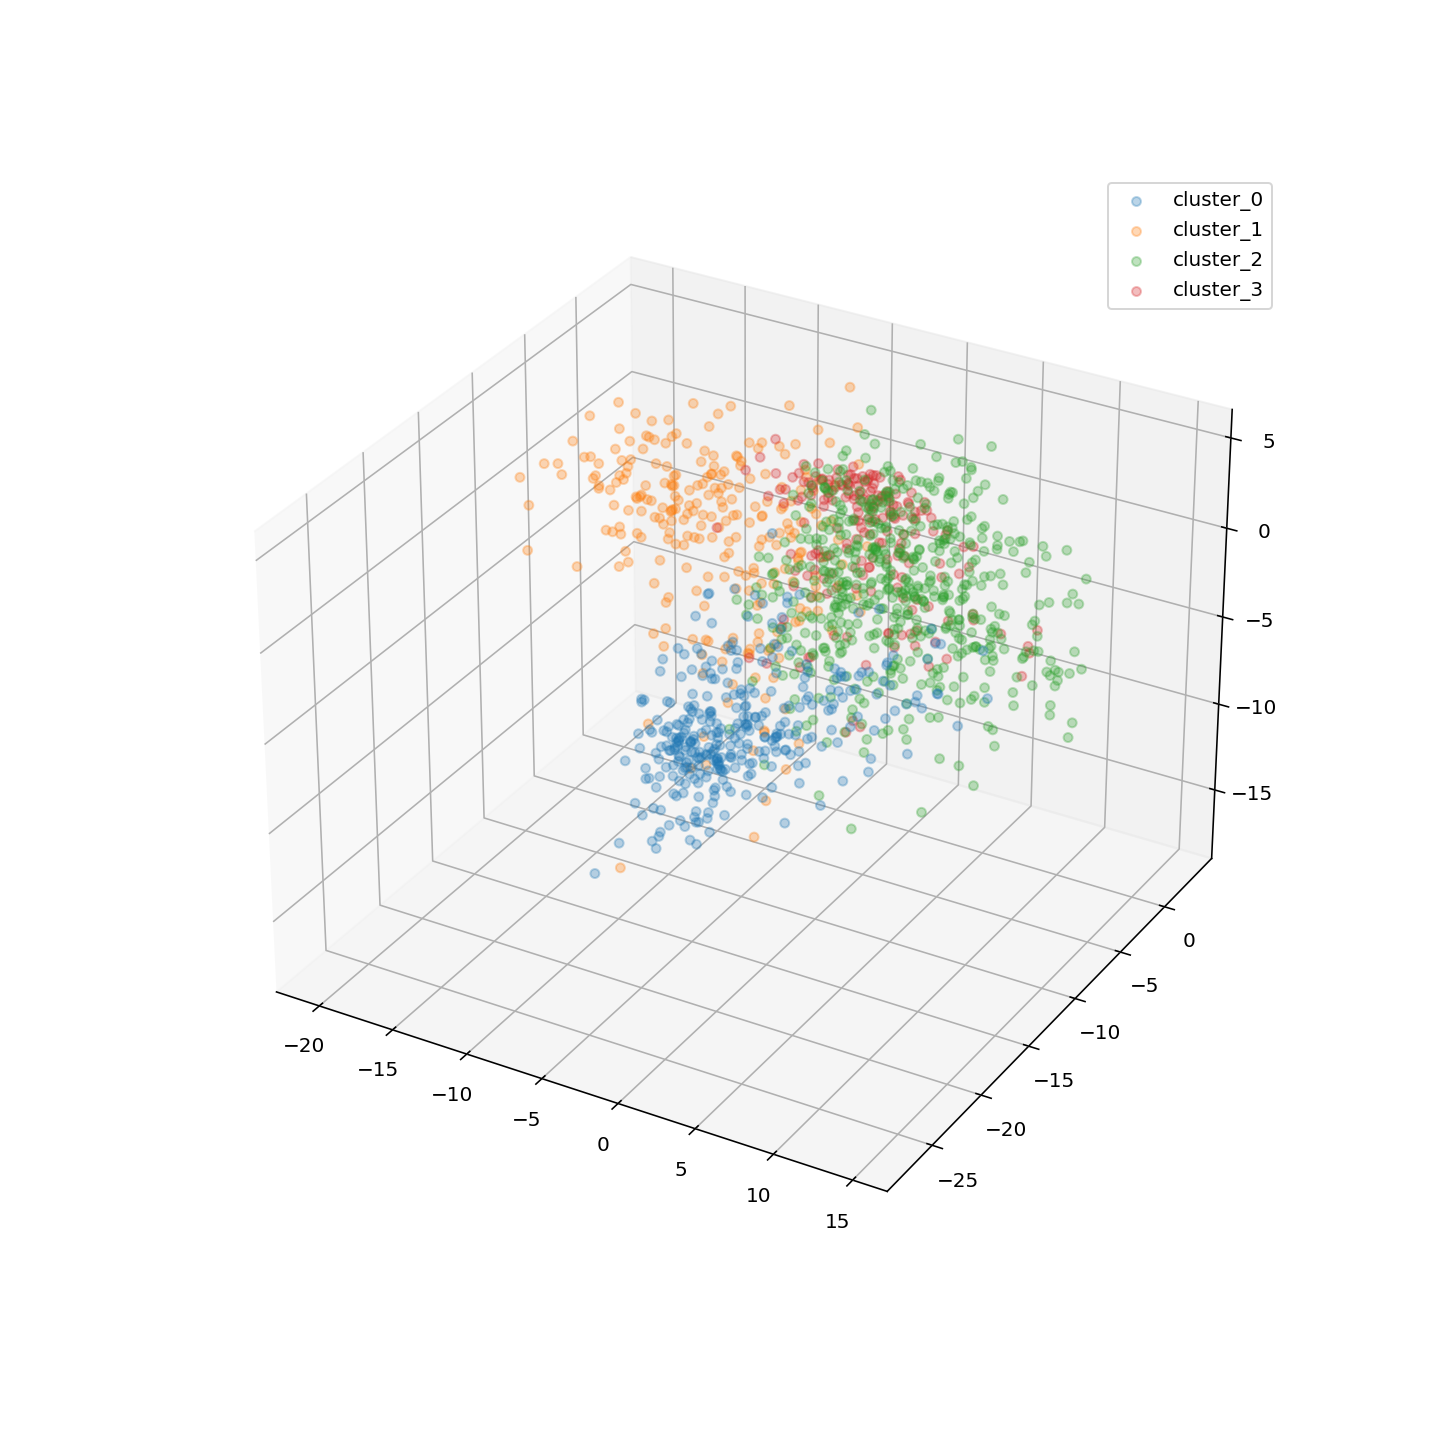

In [68]:
### Memorability changes by coordinates in each cluster
# normalized: highest R^2 (cluster 1) = 0.318
# mobius: highest R^2 (cluster 3) = 0.123

%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
# ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
# ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
# ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
# ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

plt.legend()


On cluster level, typicality and cartesian coordinates of concepts explained 3% more variance in memorability than coordinates alone. 

In [69]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.16992513686139177

In [70]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.1603862801583964

In [71]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.0718266713289869

In [115]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.tools.sm_exceptions import ConvergenceWarning

# md = smf.mixedlm("cr ~ typicality", typ_coord_cluster, groups=typ_coord_cluster["label"], re_formula="~typicality")
# mdf = md.fit(method=["lbfgs"])
# print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    cr       
No. Observations:     1324       Method:                REML     
No. Groups:           3          Scale:                 0.0014   
Min. group size:      241        Log-Likelihood:        2457.2681
Max. group size:      584        Converged:             No       
Mean group size:      441.3                                      
-----------------------------------------------------------------
                       Coef. Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.777    0.004 194.806 0.000  0.769  0.784
typicality             0.038    0.024   1.566 0.117 -0.010  0.086
Group Var              0.000    0.001                            
Group x typicality Cov 0.000    0.005                            
typicality Var         0.002    0.055                            



/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.969637
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [72]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     54.88
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.27e-23
Time:                        13:31:00   Log-Likelihood:                -1825.8
No. Observations:                1324   AIC:                             3658.
Df Residuals:                    1321   BIC:                             3673.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2089      0.026     -7.998      0.0

## Categories

<IPython.core.display.Javascript object>


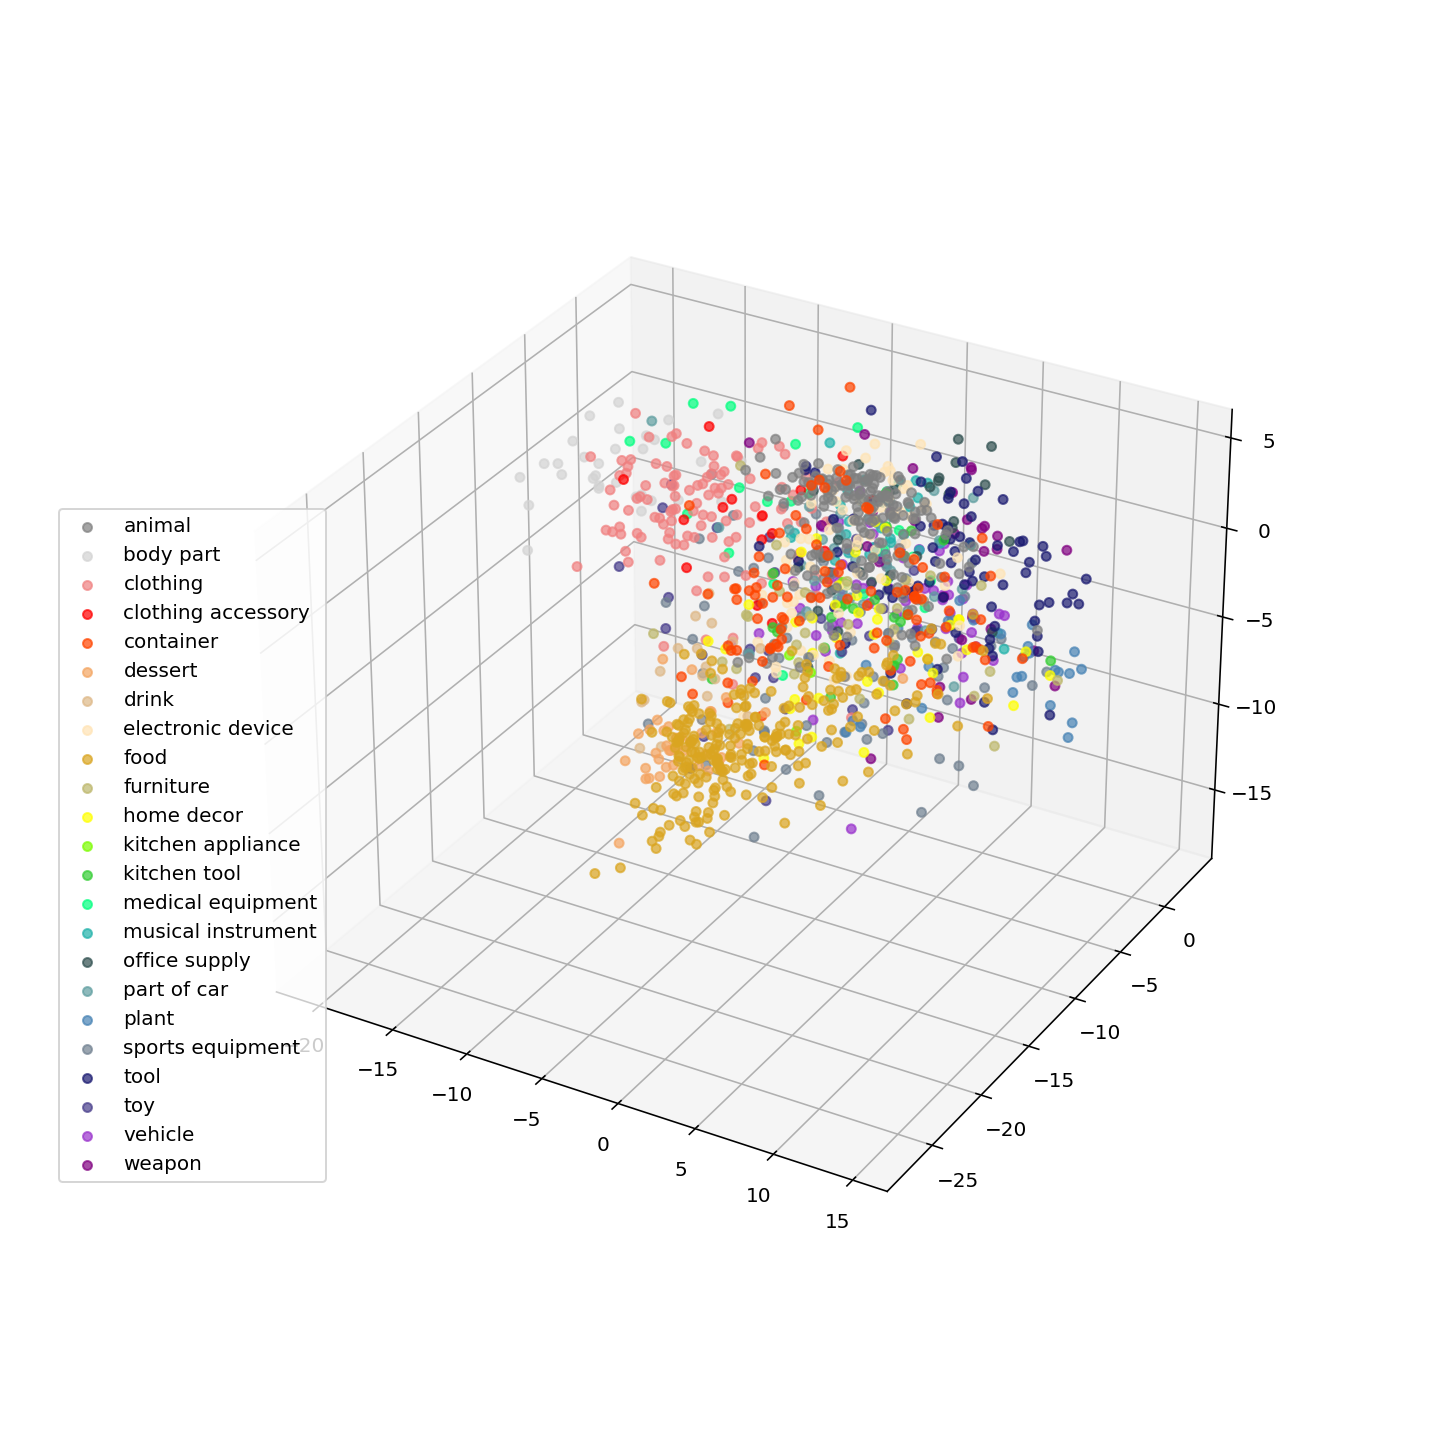

In [73]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

groups = mean_concept_in_feat_cat_na.groupby("cat_name")
i = 3
for name, group in groups:
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
    i = i+6
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Typicality by cluster 

In [74]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,3,4,cr,bigcat,cat_name,label,typicality
0,0,-3.175620,-3.230498,1.610245,0.784191,-23.486532,0.779739,1,animal,3,0.770942
1,1,5.203860,-6.154479,-5.496461,-21.416855,-5.364475,0.798485,13,home decor,2,0.265079
2,2,1.506998,-2.876097,1.402605,-23.397392,-5.519164,0.752845,18,musical instrument,2,0.223658
3,4,3.461573,-7.484285,-3.130044,-17.153949,1.066825,0.794466,9,electronic device,2,0.216024
4,5,0.283580,-12.688717,-3.592896,-16.840011,-3.229937,0.806000,12,furniture,2,0.194634
...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,-5.984330,-7.065097,-8.038232,-12.377857,-8.080542,0.803129,24,toy,1,0.097014
1320,1848,1.051345,-25.016664,-1.051580,-3.120613,-6.188148,0.765881,10,food,0,0.760288
1321,1850,-0.275887,-25.198706,-3.784909,-1.879166,-9.155138,0.843158,10,food,0,0.727667
1322,1851,-1.372886,-3.626559,0.306580,-1.510485,-21.924238,0.800163,1,animal,3,0.725081


In [75]:
### overall cartesian coordinates vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2,3,4]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     616.1
Date:                Wed, 28 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:31:15   Log-Likelihood:                -1080.9
No. Observations:                1324   AIC:                             2174.
Df Residuals:                    1318   BIC:                             2205.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0076      0.003      2.978      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [76]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2,3, 'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     74.25
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.25e-68
Time:                        13:31:30   Log-Likelihood:                -1714.4
No. Observations:                1324   AIC:                             3441.
Df Residuals:                    1318   BIC:                             3472.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0579      0.004    -14.039      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [87]:
### overall polar coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

NameError: name 'r' is not defined

In [77]:
### overall radius vs. typicality
concept_radius_clus = np.sqrt((clusters[[0,1,2,3,4]]**2).sum(1))
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     815.4
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          4.31e-140
Time:                        13:31:44   Log-Likelihood:                -1560.6
No. Observations:                1324   AIC:                             3125.
Df Residuals:                    1322   BIC:                             3136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1841      0.006     28.555      0.0

In [80]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters[[0,1,2,3,4]]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     45.67
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           6.64e-20
Time:                        13:32:20   Log-Likelihood:                -1834.4
No. Observations:                1324   AIC:                             3675.
Df Residuals:                    1321   BIC:                             3690.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0107      0.010     -1.065      0.2

In [81]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2,3,4, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     8.067
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.91e-08
Time:                        13:32:24   Log-Likelihood:                -448.04
No. Observations:                 332   AIC:                             910.1
Df Residuals:                     325   BIC:                             936.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0110      0.019      0.579      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
### cluster 0: polar coordinates + typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2,3,4]] = cart_to_polar(cluster_0[[0,1,2,3,4]].values) - cart_to_polar(clusters[[0,1,2,3,4]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,3,4,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     7.578
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.27e-07
Time:                        13:32:33   Log-Likelihood:                -449.35
No. Observations:                 332   AIC:                             912.7
Df Residuals:                     325   BIC:                             939.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0719      0.034      2.134      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:4]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     17.94
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           4.01e-08
Time:                        13:32:39   Log-Likelihood:                -453.90
No. Observations:                 332   AIC:                             913.8
Df Residuals:                     329   BIC:                             925.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0577      0.031      1.852      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [84]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,3,4, 'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     19.96
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           5.25e-19
Time:                        13:32:42   Log-Likelihood:                -311.60
No. Observations:                 255   AIC:                             637.2
Df Residuals:                     248   BIC:                             662.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0573      0.016     -3.683      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [85]:
### cluster 1: polar coordinates + typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2,3,4]] = cart_to_polar(cluster_1[[0,1,2,3,4]].values) - cart_to_polar(clusters[[0,1,2,3,4]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,3,4,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     18.97
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.71e-18
Time:                        13:32:49   Log-Likelihood:                -313.68
No. Observations:                 255   AIC:                             641.4
Df Residuals:                     248   BIC:                             666.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0102      0.019     -0.536      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [86]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:4]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     11.59
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.53e-05
Time:                        13:32:54   Log-Likelihood:                -350.61
No. Observations:                 255   AIC:                             707.2
Df Residuals:                     252   BIC:                             717.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0109      0.019      0.582      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [87]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,3,4, 'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.643
Date:                Wed, 28 Sep 2022   Prob (F-statistic):            0.00149
Time:                        13:33:04   Log-Likelihood:                -761.05
No. Observations:                 544   AIC:                             1536.
Df Residuals:                     537   BIC:                             1566.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0007      0.012     -0.054      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [88]:
### cluster 2: polar coordinates + typicality vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2,3,4]] = cart_to_polar(cluster_2[[0,1,2,3,4]].values) - cart_to_polar(clusters[[0,1,2,3,4]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,3,4,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.445
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           0.000211
Time:                        13:33:16   Log-Likelihood:                -758.72
No. Observations:                 544   AIC:                             1531.
Df Residuals:                     537   BIC:                             1562.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0057      0.020      0.288      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [89]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:4]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.269
Date:                Wed, 28 Sep 2022   Prob (F-statistic):             0.0388
Time:                        13:33:24   Log-Likelihood:                -768.64
No. Observations:                 544   AIC:                             1543.
Df Residuals:                     541   BIC:                             1556.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0410      0.016     -2.551      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [90]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,3,4, 'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     19.59
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.14e-17
Time:                        13:33:32   Log-Likelihood:                -226.58
No. Observations:                 193   AIC:                             467.2
Df Residuals:                     186   BIC:                             490.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0612      0.020     -3.013      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [91]:
### cluster 3: polar coordinates + typicality vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2,3,4]] = cart_to_polar(cluster_3[[0,1,2,3,4]].values) - cart_to_polar(clusters[[0,1,2,3,4]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,3,4,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     16.80
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.86e-15
Time:                        13:33:45   Log-Likelihood:                -232.07
No. Observations:                 193   AIC:                             478.1
Df Residuals:                     186   BIC:                             501.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0964      0.033      2.926      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [93]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:4]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     34.12
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           2.19e-13
Time:                        13:34:09   Log-Likelihood:                -244.24
No. Observations:                 193   AIC:                             494.5
Df Residuals:                     190   BIC:                             504.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0583      0.026      2.258      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [94]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.16774264140162576

In [95]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.16202123441801708

In [96]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.08430990227323065